In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random as rn
import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
RANDOM_SEED = 42
rn.seed(RANDOM_SEED)

In [3]:
df = pd.concat( pd.read_csv('SBAnational.csv', chunksize = 1000) )

# Key Points summarized I learned from Exploratory Data Analyses

1. Drop all missing values for column `MIS_Status` as this the target variable and we shouldn't fill the missing target variable.
    - I will drop these values after showing the total number of observations and variables.
    - Will encode `PIF = 1` and `CHGOFF = 0` after dropping the null values
    
2. The values of `MIS_Status` are ['P I F', 'CHGOFF', nan] which have some whitespaces, so we need to remove whitspace for better encoding

3. The variable/column `LoanNr_ChkDgt` is just to denote the primary key of the data, hence will not be used in the data analyses
4. Some of the amount columns are of the format `$60000.00` so we need to clean that data to the numeric format.
5. There are 201,667 instances where `NACIS` code is not known. Based on the paper and also general understanding, the `NACIS` can be an important feature for predicting the loan default.
    - First since, mostly 1st digits are only important for the `NACIS` to know the sector, so I just getting only first 2 characters
    - Few of the `NACIS` can be combined based on paper reading.
        - 31 to 33 : Manufacturing (combined to 33)
        - 44 to 45 : Retail Trade
        - 48 to 49 : Transportation
    - After dropping 0 `NACIS` values, I found below are the top 10 categories to which loan is disbursed
      - 23 : Construction
      - 33 : Manufacturing
      - 42 : Wholesale Trade
      - 45 : Retail Trade
      - 49 : Transportation and Warehousing
      - 54 : Information
      - 56 : Administrative ....
      - 62 : Health Care
      - 72 : Accomadation and food
      - 81 : Other services
      
6. The column `LowDoc` doesn't make any difference on the default, hence it can also be dropped.
7. Very small values for `NewExist` are missing, since the propotion of missing value is low, I am chosing to drop these values

In [4]:
text_col = ['City','Name','State','Bank','BankState','']
date_col = ['ApprovalDate','DisbursementDate']
numeric_col = ['Term','NoEmp','CreateJob','RetainedJob','DisbursementGross',
               'BalanceGross','ChgOffPrinGr','GrAppv','SBA_Appv']


# Convert dates column into Pandas datetime format
for col in date_col:
    df[col] = pd.to_datetime(df[col], format='%d-%b-%y')


# function to remove white spaces
def remove_spaces(text):
    return text.replace(' ', '')

In [5]:
# Parse numeric column values only

for col in numeric_col:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace('[^\d.]', '', regex=True).astype(float)

In [6]:
# Dictionaries to store model statistics to compare at the end

model_stat_dict = {}
model_stat_dict['ModelName'] = []
model_stat_dict['Accuracy'] = []
model_stat_dict['Precision'] = []
model_stat_dict['Recall/Sensitivity'] = []
model_stat_dict['Specificity'] = []


test_data_stat_dict = {}
test_data_stat_dict['ModelName'] = []
test_data_stat_dict['Accuracy'] = []
test_data_stat_dict['Precision'] = []
test_data_stat_dict['Recall/Sensitivity'] = []
test_data_stat_dict['Specificity'] = []

def calculate_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# 1. Data Prep and Exploration (20%)

#### 1.1 Load the data and do your initial preparation. How many observations and variables do you have?

- After encoding `MIS_Status` into 0/1 into `OutPut`, total number of columns will become 28

In [7]:
#Before dropping NA in MIS_Status
num_observations, num_variables = df.shape

formatted_num_observations = f"{num_observations:,}"
formatted_num_variables = f"{num_variables:,}"

print(f"Number of observations: {formatted_num_observations}")
print(f"Number of variables: {formatted_num_variables}")

Number of observations: 899,164
Number of variables: 27


In [8]:
# After dropping  NULL values, encode the MIS_Status into 'OutPut' column after removing blank spaces
df.dropna(subset=['MIS_Status'], inplace=True)
df.dropna(subset=['NewExist'], inplace=True)

df['MIS_Status'] = df['MIS_Status'].apply(remove_spaces)
df['OutPut'] = df['MIS_Status'].map({'PIF': 1, 'CHGOFF': 0})

num_observations, num_variables = df.shape

formatted_num_observations = f"{num_observations:,}"
formatted_num_variables = f"{num_variables:,}"

print(f"Number of observations: {formatted_num_observations}")
print(f"Number of variables: {formatted_num_variables}")

Number of observations: 897,033
Number of variables: 28


# Feature Engineering

1. Based on my data exploration and count plot shown for relation between `SBA_Appv` and `GrAppv`, it seems like if the gross amount disburesed is more than the SBA guranteed amount, then there are instance of loan default.
    - Hence I am creating a new column `IsDisburesedMore` where `True` means more money was disbursed than the guranteed one.
    - I am encoding `True = 1` and `False = 0`
    
2. Convert the `NACIS` into just 2 digits
3. Created below variables as per the paper reading:
    - `RealEstate` - loans backed by real estate will have terms 20 years or greater (≥240 months) and are the only loans granted for such a long term, whereas loans not backed by real estate will have terms less than 20 years (<240 months). Therefore, the authors created a dummy variable, “RealEstate,” where “RealEstate” = 1 if “Term” ≥240 months and “RealEstate” = 0 if “Term” <240 months.
    - `New` - “New” = 1 if the business is less than or equal to 2 years old and “New” = 0 if the business is more than 2 years old
    - `Recession` - A risk indicator that consistently emerges in discussion is how the economy may impact default rates. Small business loans are affected by the economy in general, and more small business loans tend to default right before and during an economic recession. Therefore, the authors created a dummy variable, “Recession,” where “Recession” = 1 if the loans were active during the Great Recession (December 2007 to June 2009), and “Recession” = 0 for all other times.
    - `Portion` - SBA_Appv/GrAppv

In [9]:
df['IsDisburesedMore'] = df['DisbursementGross'] > df['SBA_Appv']
df['IsDisburesedMore'] = df['IsDisburesedMore'].map({True: 1, False: 0})

# convert NAICS into only first 2 digits
df['NAICS'] = df['NAICS'] // 10000
df = df[df['NAICS'] > 0].copy()


df.loc[df['NAICS'].between(31, 33), 'NAICS'] = 33
df.loc[df['NAICS'].between(44, 45), 'NAICS'] = 45
df.loc[df['NAICS'].between(48, 49), 'NAICS'] = 49


df['RealEstate'] = df['Term'] >= 240
df['RealEstate'] = df['RealEstate'].map({True: 1, False: 0})

df['ToDate'] = df['DisbursementDate'] + pd.to_timedelta(df['Term']*30, unit='D')
df['Recession'] = (df['DisbursementDate'] < '2007-12-01') & ( df['ToDate'] >= '2009-06-30')
df['Recession'] = df['Recession'].map({True: 1, False: 0})

df['New'] = df['NewExist'] < 2
df['New'] = df['New'].map({True: 1, False: 0})

df['Portion'] = df['SBA_Appv']/df['GrAppv']

#### 1.2 Select a 25% sample of the data for use in testing.

In [10]:
df_test = df.sample(frac = 0.25, random_state = RANDOM_SEED)

num_observations, num_variables = df.shape

formatted_num_observations = f"{num_observations:,}"
formatted_num_variables = f"{num_variables:,}"

print(f"Number of observations: {formatted_num_observations}")
print(f"Number of variables: {formatted_num_variables}")

Number of observations: 695,366
Number of variables: 34


In [11]:
df_test.isna().sum()

LoanNr_ChkDgt             0
Name                      0
City                      0
State                     1
Zip                       0
Bank                    163
BankState               164
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                  0
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr               593
LowDoc                  637
ChgOffDate           137803
DisbursementDate        472
DisbursementGross         0
BalanceGross              0
MIS_Status                0
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
OutPut                    0
IsDisburesedMore          0
RealEstate                0
ToDate                  472
Recession                 0
New                       0
Portion                   0
dtype: int64

In [12]:
df_test.dropna(subset=['State'], inplace=True)
df_test.isna().sum()

LoanNr_ChkDgt             0
Name                      0
City                      0
State                     0
Zip                       0
Bank                    163
BankState               164
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                  0
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr               593
LowDoc                  637
ChgOffDate           137802
DisbursementDate        472
DisbursementGross         0
BalanceGross              0
MIS_Status                0
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
OutPut                    0
IsDisburesedMore          0
RealEstate                0
ToDate                  472
Recession                 0
New                       0
Portion                   0
dtype: int64

#### 1.3 Describe the distribution of the outcome variable. What is the majority class?

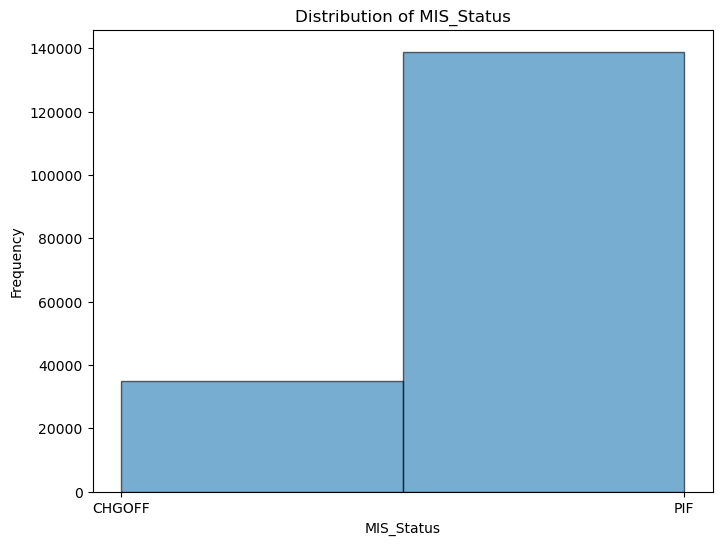

Frequency of 'CHGOFF' (0): 34,949
Frequency of 'PIF' (1): 138,892
Majority Class: PIF


In [13]:
# Create a histogram to visualize the distribution of 'MIS_Status'
plt.figure(figsize=(8, 6))
plt.hist(df_test['OutPut'], bins=[0, 0.5, 1], edgecolor='black', alpha=0.6)
plt.title('Distribution of MIS_Status')
plt.xlabel('MIS_Status')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['CHGOFF', 'PIF'])

# Calculate the frequency of each class
value_counts = df_test['OutPut'].value_counts()
majority_class = value_counts.idxmax()

# Display the histogram
plt.show()

# Print the frequency of each class and the majority class
print(f"Frequency of 'CHGOFF' (0): {value_counts[0]:,}")
print(f"Frequency of 'PIF' (1): {value_counts[1]:,}")
print("Majority Class:", 'PIF' if majority_class == 1 else 'CHGOFF')

#### 1.4 What is the accuracy, precision, and recall of the majority-class classifier on the test data?

In [14]:
majority_class_predictions = [majority_class] * len(df_test)

accuracy = accuracy_score(df_test['OutPut'], majority_class_predictions)

precision = precision_score(df_test['OutPut'], majority_class_predictions)
recall = recall_score(df_test['OutPut'], majority_class_predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


test_data_stat_dict['ModelName'].append('TestCase-Actual')
test_data_stat_dict['Accuracy'].append(accuracy)
test_data_stat_dict['Precision'].append(precision)
test_data_stat_dict['Recall/Sensitivity'].append(recall)
test_data_stat_dict['Specificity'].append(calculate_specificity(df_test['OutPut'], majority_class_predictions))

Accuracy: 0.80
Precision: 0.80
Recall: 1.00


#### 1.5 Identify some variables that, based on our understanding and reading (e.g. the source paper!) are likely to be useful for predicting default. Describe them, our motivation, their distribution, and their relationship to outcomes (in the training data). Do feature transformations we find useful here as well. we may need to create interaction features, or do other feature transformations.

- **Loan Amount (DisbursementGross)**: The loan amount can be a significant predictor. Larger loans may have a higher risk of default. It's essential to consider the distribution and any potential transformations such as log transformation to make it more normally distributed.

- **Loan Purpose (NAICS)**: The NAICS code, which represents the industry type, can be indicative of risk. Some industries may be more prone to economic downturns than others, impacting default rates. we may consider grouping or one-hot encoding NAICS codes.

- **Loan Term (Term)**: The term of the loan can affect the likelihood of default. Longer-term loans may have a different risk profile than shorter-term loans.

- **Revolving Line of Credit (RevLineCr) and Low Documentation Loan (LowDoc)**: Binary variables that indicate whether the loan has a revolving line of credit or is a low documentation loan can influence default rates.

- **Business Location (State, City)**: The geographic location of the business may be relevant, as economic conditions can vary by region. we can create regional features or use external economic indicators to account for regional variations.

- **Loan Approval Date (ApprovalDate) and Fiscal Year (ApprovalFY)**: The time of approval can impact the likelihood of default, particularly during economic recessions. we can create time-related features or use economic indicators for the year of approval.

- **SBA Loan Amount (SBA_Appv) vs. Gross Amount Approved (GrAppv)**: Comparing the SBA-approved amount to the gross amount approved can provide insights into how much of the loan is guaranteed by the SBA. This can be a relevant variable.

In [15]:
not_req_col = ['LoanNr_ChkDgt','Name','FranchiseCode','LowDoc','ToDate','NewExist']

**I have tried to summarize the results at the end of the file**

# Subset Model (20%)

- Although `DisbursementGross` has been featured engineered into some other variables, but this amount will still impact the outcomes, so I am taking this as 5th variable for prediction


The logistic regression model exhibits an accuracy of around 79.90%, suggesting a reasonable overall predictive ability. The precision is also around 79.90%, showing that when the model predicts Class 1, it is correct approximately 79.90% of the time. The F1-Score, which balances precision and recall, is about 0.888, but the issue of no positive predictions needs to be addressed for a more balanced and meaningful model. Further investigation and potential model or data adjustments are warranted to improve its performance.


- **Test Data**
    * The accuracy has dropped to ~67% from 80% when fitted using the subset model, thus it's an indication that Subset model might not work when fitting for entire dataset

In [16]:
df_subset = df[ (df['State'] == 'CA') & (df['NAICS'] == 53)].copy()
subset_predicting_col = ['New','RealEstate','Portion','Recession','DisbursementGross']

X = df_subset[subset_predicting_col]
y = df_subset['OutPut']

# Since has large values compared to the other columns, so to avoid any biases in the model
# I am scaling it using standard scaling

scaler = StandardScaler()
X.loc[:, 'DisbursementGross'] = scaler.fit_transform(X['DisbursementGross'].values.reshape(-1, 1))

# Test Train split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


# Create a logistic regression model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)



LogisticRegression()

In [17]:
confusion = confusion_matrix(y_test, log_model.predict(X_test))
precision = precision_score(y_test, log_model.predict(X_test))
recall = recall_score(y_test, log_model.predict(X_test))
accuracy = log_model.score(X_test, y_test)
f1 = f1_score(y_test, log_model.predict(X_test))

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-Score: {f1}")

print("Confusion Matrix:")
print(confusion)

model_stat_dict['ModelName'].append('Logistic-SubSet')
model_stat_dict['Accuracy'].append(accuracy)
model_stat_dict['Precision'].append(precision)
model_stat_dict['Recall/Sensitivity'].append(recall)
model_stat_dict['Specificity'].append(calculate_specificity(y_test, log_model.predict(X_test)))


# On test data
df_subset = df_test[ (df_test['State'] == 'CA') & (df_test['NAICS'] == 53)].copy()
subset_predicting_col = ['New','RealEstate','Portion','Recession','DisbursementGross']

X = df_subset[subset_predicting_col]
y = df_subset['OutPut']


confusion_test = confusion_matrix(y, log_model.predict(X))
precision_test = precision_score(y, log_model.predict(X))
recall_test = recall_score(y, log_model.predict(X))
accuracy_test = log_model.score(X, y)
f1_test = f1_score(y, log_model.predict(X))

test_data_stat_dict['ModelName'].append('Logistic-SubSet')
test_data_stat_dict['Accuracy'].append(accuracy)
test_data_stat_dict['Precision'].append(precision)
test_data_stat_dict['Recall/Sensitivity'].append(recall)
test_data_stat_dict['Specificity'].append(calculate_specificity(y, log_model.predict(X)))

print('='*50)
print('For Test Data Set')


print(f"Accuracy: {accuracy_test}")
print(f"Recall: {recall_test}")
print(f"Precision: {precision_test}")
print(f"F1-Score: {f1_test}")

print("Confusion Matrix:")
print(confusion_test)

Accuracy: 0.6705607476635514
Recall: 0.9202898550724637
Precision: 0.6809651474530831
F1-Score: 0.7827426810477657
Confusion Matrix:
[[ 33 119]
 [ 22 254]]
For Test Data Set
Accuracy: 0.6691729323308271
Recall: 1.0
Precision: 0.6691729323308271
F1-Score: 0.8018018018018018
Confusion Matrix:
[[  0 176]
 [  0 356]]


# Full Model (20%)

1. Include State and Industry Terms?
    - State and industry terms are valueable vairables as we saw in the paper and exploratory analyses that default rater vary by `NAICS` and `State`. We need to encode each category
2. Do you need to use interaction terms? Are there additional features that are useful?
    - There were two significant interaction effects: “RealEstate*Portion” and “Recession*Portion”
    - Other than this I didn't found anything else to be important from comparing the correaltion in exploratory file
    
    
- Choosing these as the input features ->['New','RealEstate','Portion','Recession','DisbursementGross', 'RealEstatePortion','RecessionPortion']
    * The logistic regression model exhibits a high accuracy of approximately 79.90% on the test data, but it has a low recall (sensitivity) of nearly 100%, indicating that it rarely misses actual positive instances. The precision is around 79.90%, while the F1-Score is about 0.888, balancing precision and recall. The confusion matrix shows very few false positives and four false negatives. The cross-validation results demonstrate consistent performance with a mean accuracy of approximately 79.76% and minimal variability (standard deviation of 0.000056). The model seems to predict the majority class frequently, warranting further evaluation of its ability to identify the minority class.
    
    
- **Test Data**
    * The accuracy (~80%) is very much close to the actual accuracy when fit on the full size data.
    * This accuracy doesn't change much if we change input variables from `input_vars_col1` or `input_vars_col2` or `input_vars_col2`
        - This might be an indication that choice of input variable will not have much impact on logistic regression

In [18]:
df['RealEstatePortion'] = df['RealEstate']*df['Portion']
df['RecessionPortion'] = df['Recession']*df['Portion']

df_test['RealEstatePortion'] = df_test['RealEstate']*df_test['Portion']
df_test['RecessionPortion'] = df_test['Recession']*df_test['Portion']

In [19]:
columns_use = ['New','RealEstate','Portion','Recession','State','NAICS','DisbursementGross','OutPut',
                   'RealEstatePortion','RecessionPortion']

df_temp = df[columns_use].copy()
df_encoded = pd.get_dummies(df_temp, columns=['State'], drop_first=True).copy()
df_encoded = pd.get_dummies(df_temp, columns=['NAICS'], drop_first=True)

df_encoded_test = pd.get_dummies(df_test, columns=['State'], drop_first=True).copy()
df_encoded_test = pd.get_dummies(df_test, columns=['NAICS'], drop_first=True)

In [20]:
columns_use.remove('State')
columns_use.remove('NAICS')
columns_use.remove('OutPut')

X = df_encoded[columns_use].copy()
y = df_encoded['OutPut'].copy()

X.loc[:, 'DisbursementGross'] = scaler.fit_transform(X['DisbursementGross'].values.reshape(-1, 1))
X.loc[:, 'RealEstatePortion'] = scaler.fit_transform(X['RealEstatePortion'].values.reshape(-1, 1))
X.loc[:, 'RecessionPortion'] = scaler.fit_transform(X['RecessionPortion'].values.reshape(-1, 1))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

full_model = LogisticRegression()
full_model.fit(X_train, y_train)

confusion = confusion_matrix(y_test, full_model.predict(X_test))
precision = precision_score(y_test, full_model.predict(X_test))
recall = recall_score(y_test, full_model.predict(X_test))
accuracy = full_model.score(X_test, y_test)
f1 = f1_score(y_test, full_model.predict(X_test))

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-Score: {f1}")

print("Confusion Matrix:")
print(confusion)


model_stat_dict['ModelName'].append('Logistic-FullModel')
model_stat_dict['Accuracy'].append(accuracy)
model_stat_dict['Precision'].append(precision)
model_stat_dict['Recall/Sensitivity'].append(recall)
model_stat_dict['Specificity'].append(calculate_specificity(y_test, full_model.predict(X_test)))


# On test data
X = df_encoded_test[columns_use].copy()
y = df_encoded_test['OutPut'].copy()

X.loc[:, 'DisbursementGross'] = scaler.fit_transform(X['DisbursementGross'].values.reshape(-1, 1))
X.loc[:, 'RealEstatePortion'] = scaler.fit_transform(X['RealEstatePortion'].values.reshape(-1, 1))
X.loc[:, 'RecessionPortion'] = scaler.fit_transform(X['RecessionPortion'].values.reshape(-1, 1))

confusion_test = confusion_matrix(y, full_model.predict(X))
precision_test = precision_score(y, full_model.predict(X))
recall_test = recall_score(y, full_model.predict(X))
accuracy_test = full_model.score(X, y)
f1_test = f1_score(y, full_model.predict(X))

print(f"Accuracy: {accuracy_test}")
print(f"Recall: {recall_test}")
print(f"Precision: {precision_test}")
print(f"F1-Score: {f1_test}")

print("Confusion Matrix:")
print(confusion_test)


test_data_stat_dict['ModelName'].append('Logistic-FullModel')
test_data_stat_dict['Accuracy'].append(accuracy)
test_data_stat_dict['Precision'].append(precision)
test_data_stat_dict['Recall/Sensitivity'].append(recall)
test_data_stat_dict['Specificity'].append(calculate_specificity(y, full_model.predict(X)))

print('='*50)
print('For Test Data Set')


print(f"Accuracy: {accuracy_test}")
print(f"Recall: {recall_test}")
print(f"Precision: {precision_test}")
print(f"F1-Score: {f1_test}")

print("Confusion Matrix:")
print(confusion_test)

Accuracy: 0.7989631419244431
Recall: 0.9999640025558185
Precision: 0.7989861220967858
F1-Score: 0.8882484841459856
Confusion Matrix:
[[     0  27955]
 [     4 111115]]
Accuracy: 0.7989197024867551
Recall: 0.9999496011289347
Precision: 0.7989518736265633
F1-Score: 0.888221638111318
Confusion Matrix:
[[     0  34949]
 [     7 138885]]
For Test Data Set
Accuracy: 0.7989197024867551
Recall: 0.9999496011289347
Precision: 0.7989518736265633
F1-Score: 0.888221638111318
Confusion Matrix:
[[     0  34949]
 [     7 138885]]


- I tried using columns ['New','RealEstate','Portion','Recession','DisbursementGross','IsDisburesedMore'], however this doesn't make any difference in the model performance.
    So we can go with the above model only as it has stronger opinioin in paper

In [21]:
def fit_test_model_for_given_cols(df, model, cols, RANDOM_SEED,model_stat_dict,
                                  model_name,df_test,test_data_stat_dict):
    
    
    input_cols = copy.deepcopy(cols)
    if 'OutPut' not in input_cols:
        input_cols.append('OutPut')
    test_df = df_test.copy()
    
    df_temp = df[input_cols].copy()
    df_encoded = df_temp 
    df_encoded_test = test_df 
    if 'State' in input_cols:
        df_encoded = pd.get_dummies(df_temp, columns=['State'], drop_first=True).copy()
        df_encoded_test = pd.get_dummies(test_df, columns=['State'], drop_first=True).copy()
        input_cols.remove('State')
    
    if 'NAICS' in input_cols:
        df_encoded = pd.get_dummies(df_temp, columns=['NAICS'], drop_first=True)
        df_encoded_test = pd.get_dummies(test_df, columns=['NAICS'], drop_first=True)
        input_cols.remove('NAICS')

    if 'OutPut' in input_cols:
        input_cols.remove('OutPut')

    X = df_encoded[input_cols].copy()
    y = df_encoded['OutPut'].copy()
    
    if 'DisbursementGross' in input_cols:
        X.loc[:, 'DisbursementGross'] = scaler.fit_transform(X['DisbursementGross'].values.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
    
    model.fit(X_train, y_train)

    confusion = confusion_matrix(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))
    accuracy = model.score(X_test, y_test)
    f1 = f1_score(y_test, model.predict(X_test))

    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1-Score: {f1}")

    print("Confusion Matrix:")
    print(confusion)
    
    model_stat_dict['ModelName'].append(model_name)
    model_stat_dict['Accuracy'].append(accuracy)
    model_stat_dict['Precision'].append(precision)
    model_stat_dict['Recall/Sensitivity'].append(recall)
    model_stat_dict['Specificity'].append(calculate_specificity(y_test, model.predict(X_test)))
    
    
    # For test data
    X = df_encoded_test[input_cols].copy()
    y = df_encoded_test['OutPut'].copy()

    X.loc[:, 'DisbursementGross'] = scaler.fit_transform(X['DisbursementGross'].values.reshape(-1, 1))
    
    confusion_test = confusion_matrix(y, model.predict(X))
    precision_test = precision_score(y, model.predict(X))
    recall_test = recall_score(y, model.predict(X))
    accuracy_test = model.score(X, y)
    f1_test = f1_score(y, model.predict(X))
    
    print('='*50)
    print('For Test Data Set')
    print(f"Accuracy: {accuracy_test}")
    print(f"Recall: {recall_test}")
    print(f"Precision: {precision_test}")
    print(f"F1-Score: {f1_test}")

    print("Confusion Matrix:")
    print(confusion_test)
    
    test_data_stat_dict['ModelName'].append(model_name)
    test_data_stat_dict['Accuracy'].append(accuracy)
    test_data_stat_dict['Precision'].append(precision)
    test_data_stat_dict['Recall/Sensitivity'].append(recall)
    test_data_stat_dict['Specificity'].append(calculate_specificity(y, model.predict(X)))

In [22]:
input_vars_col1 = ['New','RealEstate','Portion','Recession','DisbursementGross','State','NAICS','OutPut',
                       'RealEstatePortion','RecessionPortion']
input_vars_col2 = ['New','RealEstate','Portion','Recession','DisbursementGross','State','NAICS','OutPut',
                       'IsDisburesedMore']
input_vars_col3 = ['New','RealEstate','Portion','Recession','DisbursementGross','State','NAICS','OutPut',
                       'RealEstatePortion','RecessionPortion', 'IsDisburesedMore']

In [23]:
full_model_test = LogisticRegression()

print(f'With input columns\n {input_vars_col1}')
fit_test_model_for_given_cols(df, full_model_test, input_vars_col1, RANDOM_SEED, 
                              model_stat_dict,'Logistic-FullModel-Col1',df_test,test_data_stat_dict)
print('='*50)

print(f'With input columns\n {input_vars_col2}')
fit_test_model_for_given_cols(df, full_model_test, input_vars_col2, RANDOM_SEED, 
                              model_stat_dict, 'Logistic-FullModel-Col2',df_test,test_data_stat_dict)
print('='*50)


print(f'With input columns\n {input_vars_col3}')
fit_test_model_for_given_cols(df, full_model_test, input_vars_col3, RANDOM_SEED, 
                              model_stat_dict, 'Logistic-FullModel-Col3',df_test,test_data_stat_dict)
print('='*50)

With input columns
 ['New', 'RealEstate', 'Portion', 'Recession', 'DisbursementGross', 'State', 'NAICS', 'OutPut', 'RealEstatePortion', 'RecessionPortion']
Accuracy: 0.7989631419244431
Recall: 0.9999640025558185
Precision: 0.7989861220967858
F1-Score: 0.8882484841459856
Confusion Matrix:
[[     0  27955]
 [     4 111115]]
For Test Data Set
Accuracy: 0.7989197024867551
Recall: 0.9999496011289347
Precision: 0.7989518736265633
F1-Score: 0.888221638111318
Confusion Matrix:
[[     0  34949]
 [     7 138885]]
With input columns
 ['New', 'RealEstate', 'Portion', 'Recession', 'DisbursementGross', 'State', 'NAICS', 'OutPut', 'IsDisburesedMore']
Accuracy: 0.798991903590894
Recall: 1.0
Precision: 0.798991903590894
F1-Score: 0.8882662584484777
Confusion Matrix:
[[     0  27955]
 [     0 111119]]
For Test Data Set
Accuracy: 0.7989599691672276
Recall: 1.0
Precision: 0.7989599691672276
F1-Score: 0.8882465233921588
Confusion Matrix:
[[     0  34949]
 [     0 138892]]
With input columns
 ['New', 'RealE

# Regularized Regression (15%)

1. **With L1 Regularization**

- **Test Data**
    * The accuracy (~80%) is very much close to the actual accuracy when fit on the full size data.
    * This accuracy doesn't change much if we change input variables from `input_vars_col1` or `input_vars_col2` or `input_vars_col2`
        - This might be an indication that choice of input variable will not have much impact on logistic regression

In [24]:
lasso_model = LogisticRegression(penalty='l1', solver='liblinear')


print(f'With input columns\n {subset_predicting_col}')
fit_test_model_for_given_cols(df, lasso_model, subset_predicting_col, RANDOM_SEED, 
                              model_stat_dict,'L1-Reg-5-Col',df_test,test_data_stat_dict)
print('='*50)


print(f'With input columns\n {input_vars_col1}')
fit_test_model_for_given_cols(df, lasso_model, input_vars_col1, RANDOM_SEED, 
                              model_stat_dict,'L1-Reg-Col1',df_test,test_data_stat_dict)
print('='*50)

print(f'With input columns\n {input_vars_col2}')
fit_test_model_for_given_cols(df, lasso_model, input_vars_col2, RANDOM_SEED, 
                              model_stat_dict,'L1-Reg-Col1',df_test,test_data_stat_dict)
print('='*50)


print(f'With input columns\n {input_vars_col3}')
fit_test_model_for_given_cols(df, lasso_model, input_vars_col3, RANDOM_SEED, 
                              model_stat_dict,'L1-Reg-Col1',df_test,test_data_stat_dict)
print('='*50)

With input columns
 ['New', 'RealEstate', 'Portion', 'Recession', 'DisbursementGross']
Accuracy: 0.798991903590894
Recall: 1.0
Precision: 0.798991903590894
F1-Score: 0.8882662584484777
Confusion Matrix:
[[     0  27955]
 [     0 111119]]
For Test Data Set
Accuracy: 0.7989599691672276
Recall: 1.0
Precision: 0.7989599691672276
F1-Score: 0.8882465233921588
Confusion Matrix:
[[     0  34949]
 [     0 138892]]
With input columns
 ['New', 'RealEstate', 'Portion', 'Recession', 'DisbursementGross', 'State', 'NAICS', 'OutPut', 'RealEstatePortion', 'RecessionPortion']
Accuracy: 0.7989631419244431
Recall: 0.9999640025558185
Precision: 0.7989861220967858
F1-Score: 0.8882484841459856
Confusion Matrix:
[[     0  27955]
 [     4 111115]]
For Test Data Set
Accuracy: 0.7989197024867551
Recall: 0.9999496011289347
Precision: 0.7989518736265633
F1-Score: 0.888221638111318
Confusion Matrix:
[[     0  34949]
 [     7 138885]]
With input columns
 ['New', 'RealEstate', 'Portion', 'Recession', 'DisbursementGro

2. **With ElasticNet Regularization**

- **Test Data** The results are pretty much as the L1 regularizations. The predicted accuracy is ~80% for the test case which matches with the actual accuracy.

In [25]:
elasticnet_model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)

print(f'With input columns\n {subset_predicting_col}')
fit_test_model_for_given_cols(df, elasticnet_model, subset_predicting_col, RANDOM_SEED, 
                              model_stat_dict,'ElasticNet-Reg-5-Col',df_test,test_data_stat_dict)
print('='*50)


print(f'With input columns\n {input_vars_col1}')
fit_test_model_for_given_cols(df, elasticnet_model, input_vars_col1, RANDOM_SEED, 
                              model_stat_dict,'ElasticNet-Reg-Col1',df_test,test_data_stat_dict)
print('='*50)

print(f'With input columns\n {input_vars_col2}')
fit_test_model_for_given_cols(df, elasticnet_model, input_vars_col2, RANDOM_SEED, 
                              model_stat_dict,'ElasticNet-Reg-Col1',df_test,test_data_stat_dict)
print('='*50)


print(f'With input columns\n {input_vars_col3}')
fit_test_model_for_given_cols(df, elasticnet_model, input_vars_col3, RANDOM_SEED, 
                              model_stat_dict,'ElasticNet-Reg-Col1',df_test,test_data_stat_dict)
print('='*50)

With input columns
 ['New', 'RealEstate', 'Portion', 'Recession', 'DisbursementGross']
Accuracy: 0.798991903590894
Recall: 1.0
Precision: 0.798991903590894
F1-Score: 0.8882662584484777
Confusion Matrix:
[[     0  27955]
 [     0 111119]]
For Test Data Set
Accuracy: 0.7989599691672276
Recall: 1.0
Precision: 0.7989599691672276
F1-Score: 0.8882465233921588
Confusion Matrix:
[[     0  34949]
 [     0 138892]]
With input columns
 ['New', 'RealEstate', 'Portion', 'Recession', 'DisbursementGross', 'State', 'NAICS', 'OutPut', 'RealEstatePortion', 'RecessionPortion']
Accuracy: 0.7989631419244431
Recall: 0.9999640025558185
Precision: 0.7989861220967858
F1-Score: 0.8882484841459856
Confusion Matrix:
[[     0  27955]
 [     4 111115]]
For Test Data Set
Accuracy: 0.7989312072526044
Recall: 0.9999640008063819
Precision: 0.7989541867047102
F1-Score: 0.8882287483052366
Confusion Matrix:
[[     0  34949]
 [     5 138887]]
With input columns
 ['New', 'RealEstate', 'Portion', 'Recession', 'DisbursementGr

# Random Forest (10%)

- _Challenges_: Initially I tried to use following hyper-parameter tunning but the model was taking exceptionally longer time on both my machine and google collab. To maintain the consistent result comparison across models, I was training it for different set of input variables.<br>
 `param_grid = {
    'n_estimators': [100, 200, 300],  # Adjust the number of estimators
    'max_depth': [None, 10, 20, 30],  # Adjust the maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Adjust the minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Adjust the minimum number of samples required at a leaf node
    }
    `

- Below model is tuned on less number of variables for 4 cross validations.

In [26]:
def fit_test_tree_model_for_given_cols(df, cols, RANDOM_SEED,model_stat_dict,
                                           model_name,df_test,test_data_stat_dict, param_grid, model_type = 'rf'):
    
    
    input_cols = copy.deepcopy(cols)
    if 'OutPut' not in input_cols:
        input_cols.append('OutPut')
    test_df = df_test.copy()
    
    df_temp = df[input_cols].copy()
    df_encoded = df_temp 
    df_encoded_test = test_df 
    if 'State' in input_cols:
        df_encoded = pd.get_dummies(df_temp, columns=['State'], drop_first=True).copy()
        df_encoded_test = pd.get_dummies(test_df, columns=['State'], drop_first=True).copy()
        input_cols.remove('State')
    
    if 'NAICS' in input_cols:
        df_encoded = pd.get_dummies(df_temp, columns=['NAICS'], drop_first=True)
        df_encoded_test = pd.get_dummies(test_df, columns=['NAICS'], drop_first=True)
        input_cols.remove('NAICS')

    if 'OutPut' in input_cols:
        input_cols.remove('OutPut')

    X = df_encoded[input_cols].copy()
    y = df_encoded['OutPut'].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
    
    best_classifier = None
    if model_type == 'rf':
        grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=2, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        print('='*50)
        print(f'Best Params are\n {best_params}')
        best_classifier = RandomForestClassifier(**best_params)
    
    best_classifier.fit(X_train, y_train)
    best_predictions = best_classifier.predict(X_test)
    
    confusion = confusion_matrix(y_test, best_predictions)
    precision = precision_score(y_test, best_predictions)
    recall = recall_score(y_test, best_predictions)
    accuracy = accuracy_score(y_test, best_predictions)
    f1 = f1_score(y_test, best_predictions)

    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1-Score: {f1}")

    print("Confusion Matrix:")
    print(confusion)
    
    model_stat_dict['ModelName'].append(model_name)
    model_stat_dict['Accuracy'].append(accuracy)
    model_stat_dict['Precision'].append(precision)
    model_stat_dict['Recall/Sensitivity'].append(recall)
    model_stat_dict['Specificity'].append(calculate_specificity(y_test, best_predictions) )
    
    
    # For test data
    X = df_encoded_test[input_cols].copy()
    y = df_encoded_test['OutPut'].copy()

    X.loc[:, 'DisbursementGross'] = scaler.fit_transform(X['DisbursementGross'].values.reshape(-1, 1))
    
    confusion_test = confusion_matrix(y, best_classifier.predict(X))
    precision_test = precision_score(y, best_classifier.predict(X))
    recall_test = recall_score(y, best_classifier.predict(X))
    accuracy_test = accuracy_score(y, best_classifier.predict(X))
    f1_test = f1_score(y, best_classifier.predict(X))
    
    print('='*50)
    print('For Test Data Set')
    print(f"Accuracy: {accuracy_test}")
    print(f"Recall: {recall_test}")
    print(f"Precision: {precision_test}")
    print(f"F1-Score: {f1_test}")

    print("Confusion Matrix:")
    print(confusion_test)
    
    test_data_stat_dict['ModelName'].append(model_name)
    test_data_stat_dict['Accuracy'].append(accuracy)
    test_data_stat_dict['Precision'].append(precision)
    test_data_stat_dict['Recall/Sensitivity'].append(recall)
    test_data_stat_dict['Specificity'].append(calculate_specificity(y, best_classifier.predict(X)))

In [27]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20]
}


print(f'With input columns\n {subset_predicting_col}')
fit_test_tree_model_for_given_cols(df, subset_predicting_col, RANDOM_SEED, 
                              model_stat_dict,'RandomForest-5-Col',df_test,test_data_stat_dict,param_grid)
print('='*50)


print(f'With input columns\n {input_vars_col1}')
fit_test_tree_model_for_given_cols(df, input_vars_col1, RANDOM_SEED, 
                              model_stat_dict,'RandomForest-Col1',df_test,test_data_stat_dict,param_grid)
print('='*50)


print(f'With input columns\n {input_vars_col2}')
fit_test_tree_model_for_given_cols(df, input_vars_col2, RANDOM_SEED, 
                              model_stat_dict,'RandomForest-Col2',df_test,test_data_stat_dict,param_grid)
print('='*50)


print(f'With input columns\n {input_vars_col3}')
fit_test_tree_model_for_given_cols(df, input_vars_col3, RANDOM_SEED, 
                              model_stat_dict,'RandomForest-Col3',df_test,test_data_stat_dict,param_grid)
print('='*50)


With input columns
 ['New', 'RealEstate', 'Portion', 'Recession', 'DisbursementGross']
Best Params are
 {'max_depth': 10, 'n_estimators': 300}
Accuracy: 0.8065634122841078
Recall: 0.993259478577021
Precision: 0.8084352087194099
F1-Score: 0.8913673771008149
Confusion Matrix:
[[  1802  26153]
 [   749 110370]]
For Test Data Set
Accuracy: 0.7989599691672276
Recall: 1.0
Precision: 0.7989599691672276
F1-Score: 0.8882465233921588
Confusion Matrix:
[[     0  34949]
 [     0 138892]]
With input columns
 ['New', 'RealEstate', 'Portion', 'Recession', 'DisbursementGross', 'State', 'NAICS', 'OutPut', 'RealEstatePortion', 'RecessionPortion']
Best Params are
 {'max_depth': 10, 'n_estimators': 200}
Accuracy: 0.8062038914534708
Recall: 0.9947893699547332
Precision: 0.8073740258412276
F1-Score: 0.8913366017288092
Confusion Matrix:
[[  1582  26373]
 [   579 110540]]
For Test Data Set
Accuracy: 0.7989599691672276
Recall: 1.0
Precision: 0.7989599691672276
F1-Score: 0.8882465233921588
Confusion Matrix:
[[ 

# XGBoost (5%)

In [28]:
xgb_classifier = xgb.XGBClassifier()

print(f'With input columns\n {subset_predicting_col}')
fit_test_model_for_given_cols(df, xgb_classifier, subset_predicting_col, RANDOM_SEED, 
                              model_stat_dict,'XGBoost-5-Col',df_test,test_data_stat_dict)
print('='*50)


print(f'With input columns\n {input_vars_col1}')
fit_test_model_for_given_cols(df, xgb_classifier, input_vars_col1, RANDOM_SEED, 
                              model_stat_dict,'XGBoost-Col1',df_test,test_data_stat_dict)
print('='*50)

print(f'With input columns\n {input_vars_col2}')
fit_test_model_for_given_cols(df, xgb_classifier, input_vars_col2, RANDOM_SEED, 
                              model_stat_dict,'XGBoost-Col1',df_test,test_data_stat_dict)
print('='*50)


print(f'With input columns\n {input_vars_col3}')
fit_test_model_for_given_cols(df, xgb_classifier, input_vars_col3, RANDOM_SEED, 
                              model_stat_dict,'XGBoost-Col1',df_test,test_data_stat_dict)
print('='*50)

With input columns
 ['New', 'RealEstate', 'Portion', 'Recession', 'DisbursementGross']
Accuracy: 0.8065202697844314
Recall: 0.9882918312799791
Precision: 0.8109137899206202
F1-Score: 0.8908592381075995
Confusion Matrix:
[[  2348  25607]
 [  1301 109818]]
For Test Data Set
Accuracy: 0.7883065559908192
Recall: 0.9676871238084267
Precision: 0.8061805334788894
F1-Score: 0.879581425939681
Confusion Matrix:
[[  2636  32313]
 [  4488 134404]]
With input columns
 ['New', 'RealEstate', 'Portion', 'Recession', 'DisbursementGross', 'State', 'NAICS', 'OutPut', 'RealEstatePortion', 'RecessionPortion']
Accuracy: 0.8063980327020147
Recall: 0.9891917673845158
Precision: 0.8103537252473423
F1-Score: 0.8908863232034235
Confusion Matrix:
[[  2231  25724]
 [  1201 109918]]
For Test Data Set
Accuracy: 0.7887264799443169
Recall: 0.9671687354203266
Precision: 0.8067987987987988
F1-Score: 0.8797348980981821
Confusion Matrix:
[[  2781  32168]
 [  4560 134332]]
With input columns
 ['New', 'RealEstate', 'Portion

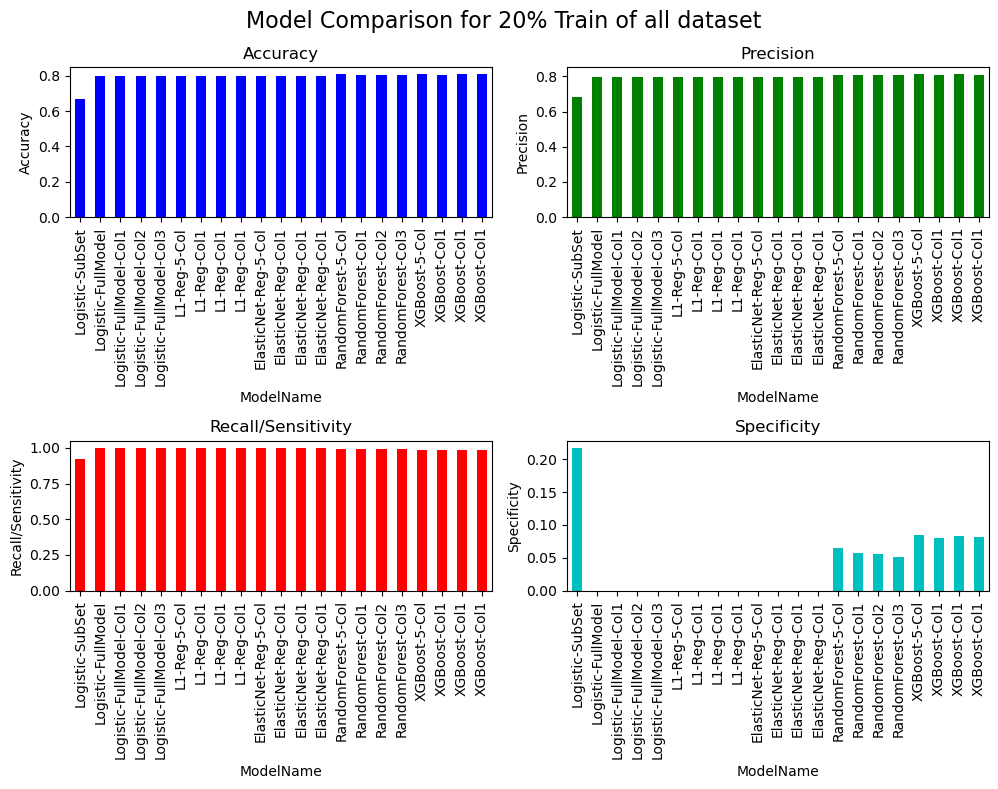

In [29]:
all_data_test_df = pd.DataFrame(model_stat_dict)
all_data_test_df.set_index('ModelName', inplace=True)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

metrics = ['Accuracy', 'Precision', 'Recall/Sensitivity', 'Specificity']
colors = ['b', 'g', 'r', 'c']

for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    all_data_test_df[metric].plot(kind='bar', ax=ax, color=colors[i])
    ax.set_title(f'{metric}')
    ax.set_ylabel(metric)
    ax.set_xlabel('ModelName')

    
plt.suptitle('Model Comparison for 20% Train of all dataset', fontsize=16)
plt.tight_layout()
plt.show()

# Final Summary and Reflection (10%)

- Only LogisticRegression for a subset of the data, RandomForest, and XGBoost were able to correctly predict True Negative instances compared to the Logistics Regression and the regularized one.
    * This is true if I changed the input variables.
    * I can say, for this dataset, Random Forest or XGBoost seems to be better model choice.
  
  However, for the Test data only XGBoost model have some specificity indiciating again that XGBoost can be a better choice of model for this datatset.

<br>
- Another observation is we can't use the model trained on Subset of data to predict for entire dataset (it has the lowest accuracy among models even much lower than the actual accuracy for the test dataset

<br>
- Same goes for the Recall, almost all models have near perfect recall except for LogisticRegression on subset of data

<br>
- Most of the models have almost same accuracy and precision (~80%) and remains less variant if we choose some different input variables.


Based on above discussion and observation, I would prefer XGBoost model among the listed models to train on this dataset as it has almost same accuracy but have much better specificity

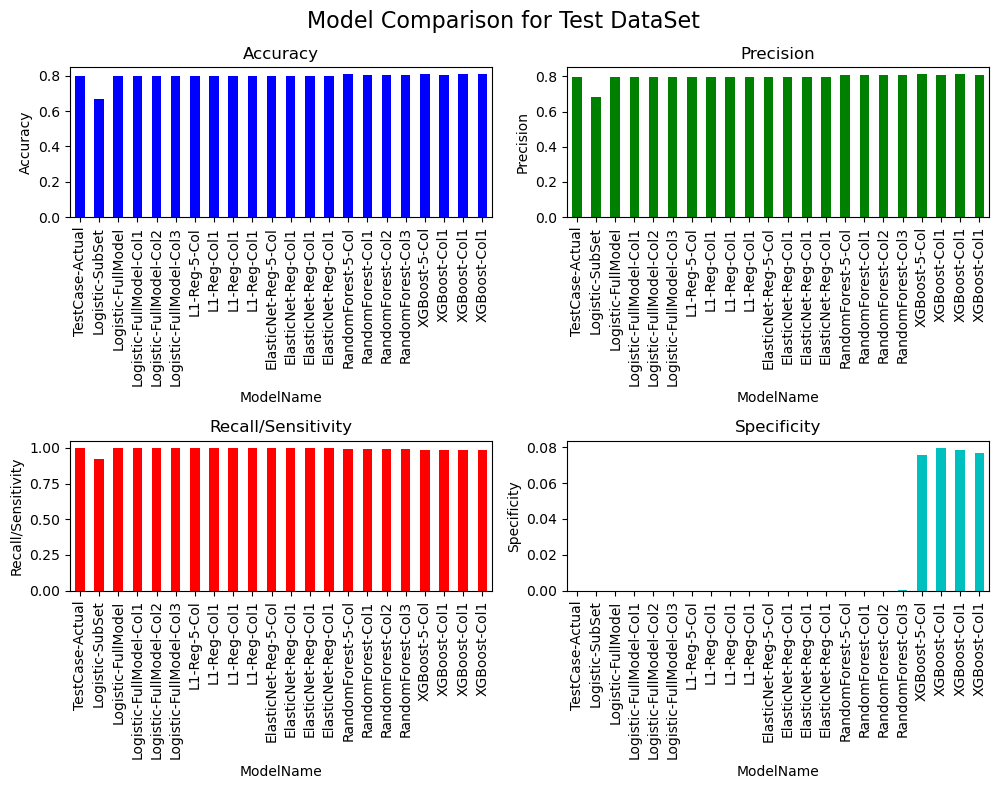

In [30]:
test_stat_df = pd.DataFrame(test_data_stat_dict)
test_stat_df.set_index('ModelName', inplace=True)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

metrics = ['Accuracy', 'Precision', 'Recall/Sensitivity', 'Specificity']
colors = ['b', 'g', 'r', 'c']

for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    test_stat_df[metric].plot(kind='bar', ax=ax, color=colors[i])
    ax.set_title(f'{metric}')
    ax.set_ylabel(metric)
    ax.set_xlabel('ModelName')
plt.suptitle('Model Comparison for Test DataSet', fontsize=16)
plt.tight_layout()
plt.show()